In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as si
import scipy.optimize as so

# change to qt for plots in a new window
%matplotlib inline

### Parameters

In [2]:
mb = 0.025   # kg # mass of squash ball
db = 0.040   # m  # diameter of ball
mc = 0.025   # kg # mass of carrier
mt = mb + mc # mass of ball + carrier

Ns = 1 # Number of springs in series
Np = 1 # Number of springs in parallel

L0 = 0.05 * Ns # m   # Length of spring
k = 1000/Ns*Np # N/m # Spring constant

# Launch angle
angle_deg = 67                       ### Here!
theta = angle_deg/180*np.pi # rad

# Gravitational acceleration
g = 9.81 # m/s^2

# Friction factor
f = 0.5 # N/(m/s)

# Spring position
xs = 0.2 # m
ys = 0.1 # m

# density and dynamic viscosity of air
rho = 1.204    # kg/m^3
mu  = 1.825e-5 # Pa s 

### Initial conditions - Spring

In [3]:
# Initial spring compression
s0 = 0.08*Ns # m                           #### Here!

# Initial velocity
v0 = 0.0 # m/s

y0 = [s0, v0]

In [4]:
# Spring equation
def spring(y, t):
    # unpack
    s, v = y
    # dsdt
    dsdt = -v
    # dvdt
    dvdt = k*s/mt - g*np.sin(theta) - f*v/mt
    
    return dsdt, dvdt

### Find maximum velocity (or zero acceleration) - Spring

In [5]:
def maxVelocity(t_end):
    t = np.linspace(0, t_end, 100)
    sol = si.odeint(spring, y0, t)
    v, a = spring(sol[-1], t_end)
    return a

Compression Dist: 0.08 m and exit vel: 10.65506706104438 m/s


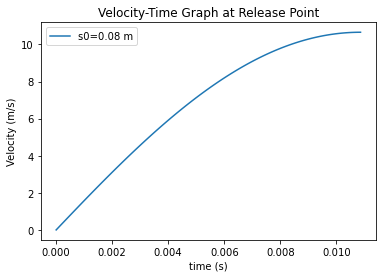

In [6]:
y0 = [s0, v0]

t_end = so.newton(maxVelocity, 0.013)

t = np.linspace(0,t_end,100)

sol = si.odeint(spring, y0, t)

s = sol[:,0]
v = sol[:,1]
plt.plot(t, v, label='s0=%0.2f m' % s0)

v_exit = v[-1]
str1 = 'Compression Dist:'
str2 = 'and exit vel:'
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity-Time Graph at Release Point')
plt.savefig('compressions.png', dpi=300)

print(str1, s0, 'm', str2, v_exit, 'm/s')

### Trajectory

In [7]:
V_mag = v_exit
Vx = V_mag*np.cos(theta)  # Hrzt comp Exit Velocity
Vy = V_mag*np.sin(theta)  # Vert comp Exit Velocity

In [8]:
# obtain drag coefficient from Reynolds number
def get_CD(Re):
    return 24/Re * (1 + 0.27*Re)**0.43 + 0.47 * (1 - np.exp(-0.04*Re**0.38))

In [9]:
# compute right hand side of governing equations at a generic
# position u, defining the x, y, Vx and Vy state variables
def squashball(u, t):
    # unpack u
    x, y, Vx, Vy = u
    
    # find theta
    # theta = np.arctan2(Vy, Vx)
    
    # magnitude of velocity
    # V_mag = np.sqrt(Vx**2 + Vy**2)
    
    # compute Reynolds number
    Re = rho * V_mag * db / mu
    
    # drag coefficient
    CD = get_CD(Re)
    
    # calculate drag
    D_mag = 0.5 * rho * V_mag**2 * CD * db**2
    
    # calculate drag components
    Dx = D_mag * np.cos(theta)
    Dy = D_mag * np.sin(theta)
    
    # calculate acceleration
    ax = - Dx/mb
    ay = - Dy/mb - g
    
    # return velocity and acceleration
    return [Vx, Vy, ax, ay]

In [10]:
# quick check to see no errors are produced
squashball([0, 0, Vx, Vy], 0)

[4.16326637689076, 9.80804094355258, -0.758349799036713, -11.59656016818261]

In [11]:
# return t, x, y, Vx, Vy given final integral time T
def trajectory(x0, y0, Vx0, Vy0, T=1):
    # pack IC into u0
    u0 = [x0, y0, Vx0, Vy0]
    
    # define array of times
    t  = np.linspace(0, T, 101)
    
    # integrate forward
    out = si.odeint(squashball, u0, t)

    # unpack data
    x  = out[:, 0]
    y  = out[:, 1]
    Vx = out[:, 2]
    Vy = out[:, 3]
    
    return t, x, y, Vx, Vy

In [12]:
# return t, x, y, Vx, Vy from given IC with y[-1] = 0
def trajectory_with_stop(x0, y0, Vx0, Vy0):

    # return y at t=T from give initial conditions
    def find_y_at_T(T):
        t, x, y, Vx, Vy = trajectory(x0, y0, Vx0, Vy0, T=T)
        return y[-1]
    
    # find T_stop such that y(T_stop) = 0
    # find T_stop such that find_y_at_T(T_stop) = 0
    T_stop = so.bisect(find_y_at_T, 0.05, 2)
    
    return trajectory(x0, y0, Vx0, Vy0, T=T_stop)

### Plot simple trajectory

In [13]:
t, x, y, Vx, Vy = trajectory_with_stop(0, 0, Vx, Vy)

Text(0.5, 1.0, 'Full Projectile')

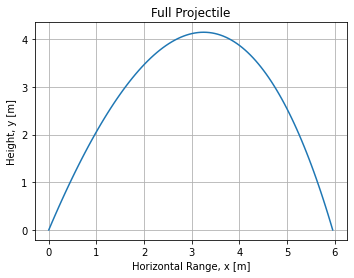

In [14]:
plt.figure(1)

plt.plot(x, y)
plt.grid(1)
plt.gca().set_aspect(1)
plt.xlabel("Horizontal Range, x [m]")
plt.ylabel("Height, y [m]")
plt.title('Full Projectile')

In [15]:
def find_range(V_mag, theta):
    return V_mag**2*np.sin(2*theta)/g

In [16]:
find_range(V_mag, theta)

8.324869945659607